In [1]:
import os
import sys
import logging
import cv2
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np

%matplotlib inline
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('PrepData')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from vehicle_detector.descriptors.hog import HOG
from vehicle_detector.descriptors import color
from vehicle_detector.utils import image_utils


with open('../data/filtered_images_path.json', 'r') as fp:
    data = json.load(fp)

vehicle_images_path = data['vehicle_images']
non_vehicle_images_path = data['non_vehicle_images']

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
def show_n_m_grid(data, cmap='gray', rows=4, cols=2, axis='off', image=True):
    f, axes = plt.subplots(rows, cols, squeeze=False, figsize=(cols*4, rows*4))
    f.tight_layout()
    
    for idx, datum in enumerate(data):
        row = idx // cols
        col = idx % cols
        if axis=='off':
            axes[row, col].axis('off')
        if image==True:
            axes[row, col].imshow(datum, cmap=cmap, aspect="auto")
        else:
            axes[row, col].plot(datum)
            
def cvt_bgr_rgb(img, cv_to_mpimg=True):
    flag = cv2.COLOR_BGR2RGB
    if not cv_to_mpimg:  # convert from mpimg to cv
        flag = cv2.COLOR_RGB2BGR
    return cv2.cvtColor(img, flag)


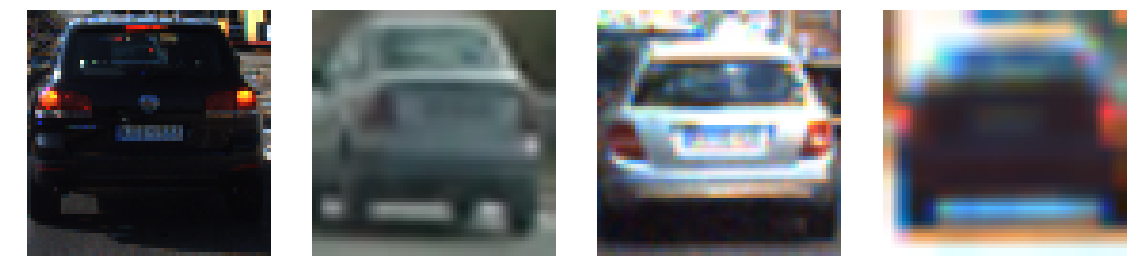

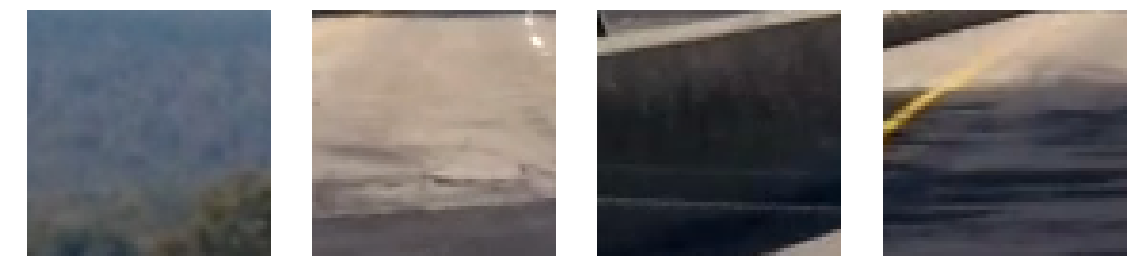

In [4]:
## Show Car Images & Non Car Images
car_indices  = np.random.randint(0, len(vehicle_images_path), size=4)
non_car_indices = np.random.randint(0, len(non_vehicle_images_path), size=4)

car_images = [cvt_bgr_rgb(cv2.imread(vehicle_images_path[i])) for i in car_indices]
non_car_images = [cvt_bgr_rgb(cv2.imread(non_vehicle_images_path[i])) for i in non_car_indices]

show_n_m_grid(car_images, cmap=None, rows=1, cols=4)
show_n_m_grid(non_car_images, cmap=None, rows=1, cols=4)

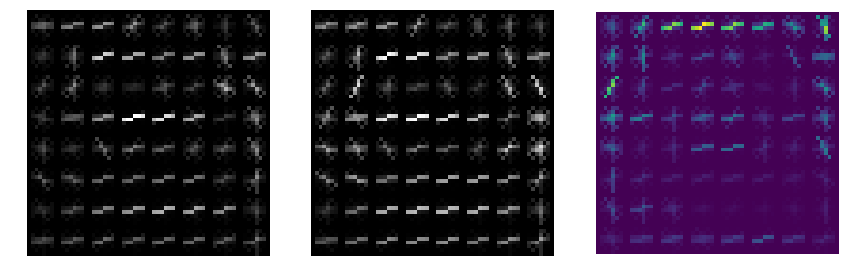

In [5]:
hog = HOG()
features, hog_images = hog.get_features(car_images[2], vis=True)
show_n_m_grid(hog_images, rows=1, cols=len(hog_images))
_, image = hog.get_features_single_channel(car_images[0][:, :, 2], vis=True)
plt.imshow(image)

In [8]:
def extract_features(img, use_color_hist, hog_descriptor, hog_cspace):
    
    color_features = []
    if use_color_hist and len(img.shape) > 2:
        color_features = color.color_hist(img, nbins=32)
    
    if hog_cspace != 'BGR':
        img = image_utils.convert_color(img, hog_cspace)

    hog_features = hog_descriptor.get_features(img, feature_vec=True)
    
    if len(img.shape) > 2:
        hog_features = np.concatenate((hog_features[0], hog_features[1], hog_features[2]))
    
    return np.concatenate((hog_features, color_features))

def extract_dataset_features(image_paths, use_color_hist, orients, n_pixels, n_cells, hog_cspace):

    features = []
    
    for img_path in tqdm(image_paths, desc='Processing image', leave=False):
        
        img = cv2.imread(img_path)
        
        if img.shape[0] != 64 or img.shape[1] != 64:
            img = cv2.resize(img, (64, 64))
        
        hog_descriptor = HOG(orients, n_pixels, n_cells)
        
        features.append(extract_features(img, use_color_hist, hog_descriptor, hog_cspace))
    return features


In [6]:
import itertools

opts_color_hist = [True, False]
opts_orients = [9, 10, 12]
opts_n_pixels= [(8,8), (12,12), (16,16)]
opts_n_cells = [(2,2), (4,4)]
opts_cspace = ['BGR2GRAY', 'BGR', 'BGR2HSV', 'BGR2YCrCb']

# Get all possible combinations of the above options
parameter_combinations = list(itertools.product(opts_color_hist, opts_orients, opts_n_pixels,
                                           opts_n_cells, opts_cspace))

In [7]:
# Create sub sample of the dataset for parameter tuning
EXPLORATION_DATASET_SIZE = 2000

car_indices = np.random.randint(0, len(vehicle_images_path), size=EXPLORATION_DATASET_SIZE)
non_car_indices = np.random.randint(0, len(non_vehicle_images_path), size=EXPLORATION_DATASET_SIZE)
car_image_paths = list(vehicle_images_path[i] for i in car_indices)
non_car_image_paths = list(non_vehicle_images_path[i] for i in non_car_indices)

# car_features = extract_dataset_features(car_image_paths, True, 9, (8,8), (2,2), 'BGR2YCrCb')
# non_car_features = extract_dataset_features(non_car_image_paths, True, 9, (8,8), (2,2), 'BGR2YCrCb')

In [11]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import multiprocessing
import time

# Set number of parallel jobs for GridSearch
CPU_COUNT = multiprocessing.cpu_count()
N_PARALLEL_JOBS = CPU_COUNT-2 if CPU_COUNT > 2 else 1


params_stats = [] # Store calculated params here
for params in tqdm(parameter_combinations, desc='Exploring params', unit='params'):
    t = time.time()

    car_features = extract_dataset_features(car_image_paths, params[0],
                                            params[1], params[2], params[3], params[4])
    non_car_features = extract_dataset_features(non_car_image_paths,params[0],
                                            params[1], params[2], params[3], params[4])

    t2 = time.time()
    avg_extraction_time = round((t2 - t) / (2* EXPLORATION_DATASET_SIZE), 5)
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, non_car_features)).astype(np.float64)
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))
    
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=rand_state)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    # Create a classifier object
    svr = svm.SVC(kernel='rbf')
    # Parameters for gridsearch
    parameters = {'C':[0.01, 0.1, 1, 10],
                  'gamma':[0.01, 0.1, 1, 10, 'auto']
                 }
    # Initialize the grid search parameters & classifier
    clf = GridSearchCV(svr, parameters, n_jobs=N_PARALLEL_JOBS)

    t = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
   
    y_pred = clf.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 3)
    
    param_name = 'CSP_{cspace}_C{cells}_B{blocks}_O{orients}_Hist_{hist}'.format(
                    hist=params[0], orients=params[1], cells=params[2],
                    blocks=params[3], cspace=params[4])
    stats = {
        'accuracy': accuracy,
        'num_features': len(car_features[0]),
        'best_params': clf.best_params_,
        'extraction_time': avg_extraction_time,
        'training_time': round(t2 - t, 2),
        'name': param_name
    }
    params_stats.append(stats)
    

In [12]:
params_stats

[{'accuracy': 97.0,
  'best_params': {'C': 10, 'gamma': 'auto'},
  'extraction_time': 0.00271,
  'name': 'CSP_BGR2GRAY_C(8, 8)_B(2, 2)_O9_Hist_True',
  'num_features': 1860,
  'training_time': 68.17},
 {'accuracy': 96.0,
  'best_params': {'C': 10, 'gamma': 'auto'},
  'extraction_time': 0.00656,
  'name': 'CSP_BGR_C(8, 8)_B(2, 2)_O9_Hist_True',
  'num_features': 5388,
  'training_time': 198.59}]